In [2]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from monai.networks import nets, one_hot

import plotly.express as px

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

import torchio as tio

from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

In [3]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import ScdEvaluator, MnmEvaluator
from tagseg.models.trainer import Trainer
from tagseg.models.segmenter import Net
from tagseg.pipelines.model_evaluation.nodes import tag_subjects
from tagseg.data.dmd_dataset import DmdDataSet

##### Case-by-case example

In [30]:
dmd_data = DmdDataSet('../data/03_primary/dmd_test.pt')._load_except(
    filepath_raw='../data/01_raw/dmd_roi'
)

In [5]:
mnm_data = MnmEvaluator('../data/03_primary/mnm_test.pt').load()

In [83]:
model = Net(
    load_model='../data/06_models/model_cine_v6_tag_v1.pt',
    model_type='SegResNetVAE'
)

subject = dmd_data[12]

batch = subject['image'][tio.DATA], subject['mask'][tio.DATA]
batch = Trainer.tensor_tuple_to('cpu', batch)
image, label = batch

image = 0.18047594 * (image - image.mean()) / image.std() + 0.72535978

preds = model.forward(image)

y_pred = preds.sigmoid()
y = one_hot(label, num_classes=2)

In [84]:
image.shape

torch.Size([1, 1, 256, 256])

In [85]:
preds.sigmoid().shape

torch.Size([1, 2, 256, 256])

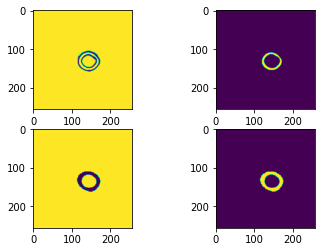

In [86]:
pred = y_pred.detach().cpu().numpy()

fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(pred[0, 0])
ax[0, 1].imshow(pred[0, 1])
ax[1, 0].imshow(y[0, 0])
ax[1, 1].imshow(y[0, 1])

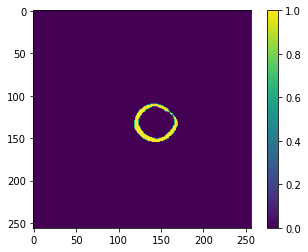

In [87]:
plt.imshow(preds.sigmoid().argmax(dim=1)[0].detach())
plt.colorbar()

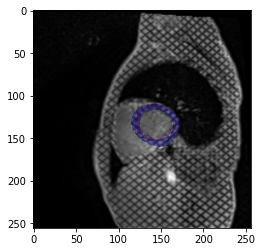

In [89]:
plt.imshow(image[0, 0], cmap='gray')
plt.imshow(np.ma.masked_where(label[0, 0] == 0, label[0, 0]), cmap='jet', alpha=0.4)

prediction = y_pred.argmax(dim=1).unsqueeze(0).detach().cpu()[0, 0]
plt.imshow(np.ma.masked_where(prediction == 0, prediction), cmap='viridis', alpha=0.4)

##### Checking results

In [90]:
dsets = ['mnm', 'scd', 'dmd']
results = {ds: PickleDataSet(f'../data/07_model_output/{ds}_results.pt').load() for ds in dsets}
dfs = {ds: pd.read_csv(f'../data/08_reporting/model_cine_v6_tag_v1/{ds}_results.csv', index_col=0) for ds in dsets}

In [91]:
dicesets = []

for ds in dsets:
    subds = dfs[ds][['dice']].copy()
    subds['dataset'] = ds
    dicesets.append(subds)

diceset = pd.concat(dicesets)

In [95]:
diceset[diceset.dice > 0].groupby('dataset').mean()

,dice
dataset,
dmd,0.515171
mnm,0.746761
scd,0.756978


In [96]:
px.histogram(diceset[diceset.dice > 0], x='dice', color='dataset', marginal='rug', barmode='overlay', nbins=20, histnorm='probability')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



0.7700103105139677


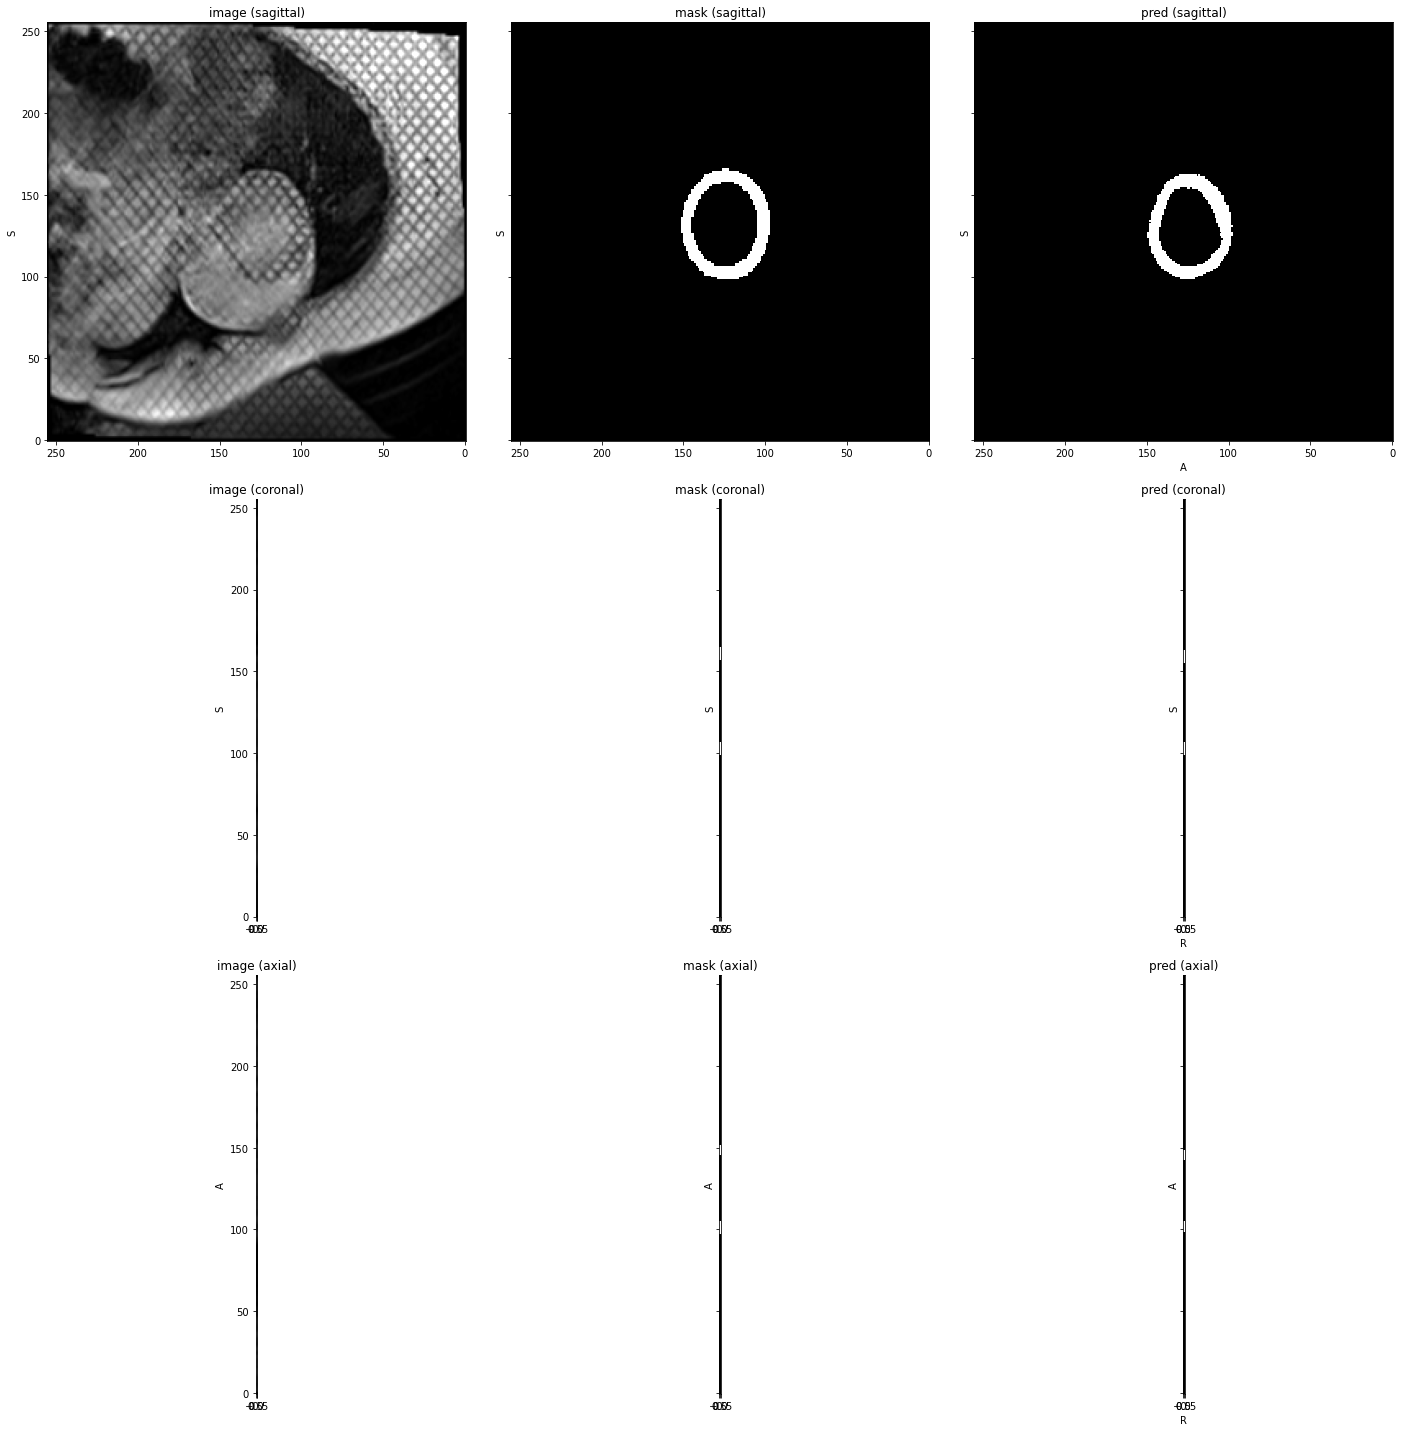

In [101]:
i = 36

print(results['dmd'][i].dice)
results['dmd'][i].plot(figsize=(20, 20))

In [35]:
px.bar(dfs['mnm'].groupby('VendorName').mean().reset_index(), x='VendorName', y='dice')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [36]:
px.bar(dfs['mnm'].groupby('Centre').mean().reset_index(), x='Centre', y='dice')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [37]:
px.bar(dfs['mnm'].groupby('Pathology').mean().reset_index(), x='Pathology', y='dice')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [42]:
px.scatter(dfs['mnm'], x=['Age', 'Height', 'Weight'], facet_col='Sex', y='dice')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



##### Checking 100 images from dataset

In [ ]:
# M, N = 20, 5
# fig, ax = plt.subplots(M, N, figsize=(20, 100))

# for i in range(M * N):
#     m, n = i % M, i // M
#     ax[m, n].imshow(tagged_subjects[i].image.data[0][0].cpu(), cmap='gray')
    
#     mask = tagged_subjects[i].mask.data[0][0].cpu()
#     mask = np.ma.masked_where(mask == 0, mask)
#     ax[m, n].imshow(mask, cmap='Reds', alpha=0.8)
    
#     ax[m, n].axis('off')